In [21]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.5)

SEED = 42

In [22]:
train_q = pd.read_excel("data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_c = pd.read_excel("data/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
train_combined = pd.merge(train_q, train_c, on='participant_id', how='left').set_index("participant_id") 


test_q = pd.read_excel("data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("data/TEST/TEST_CATEGORICAL_METADATA.xlsx")
test_combined = pd.merge(test_q, test_c, on='participant_id', how='left').set_index("participant_id")

labels = pd.read_excel("data/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

# y_adhd = labels['ADHD_Outcome']
# y_sex = labels['Sex_F']

train_combined = train_combined.sort_index()
test_combined = test_combined.sort_index()
labels = labels.sort_index()
assert all(train_combined.index == labels.index), "error"

In [23]:
train_combined.head()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,...,14.274127,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,...,NaN,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,...,13.463381,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,...,9.572553,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,...,6.654574,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


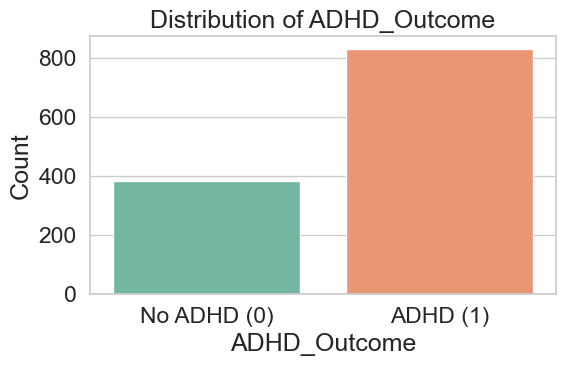

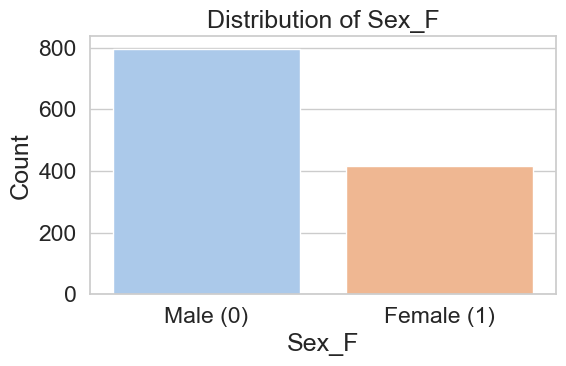

In [24]:
label_df = train_labels.copy()

# Plot: ADHD_Outcome
plt.figure(figsize=(6, 4))
sns.countplot(x=label_df["ADHD_Outcome"], palette="Set2")
plt.title("Distribution of ADHD_Outcome")
plt.xticks([0, 1], ['No ADHD (0)', 'ADHD (1)'])
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot: Sex_F
plt.figure(figsize=(6, 4))
sns.countplot(x=label_df["Sex_F"], palette="pastel")
plt.title("Distribution of Sex_F")
plt.xticks([0, 1], ['Male (0)', 'Female (1)'])
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. EDA

22


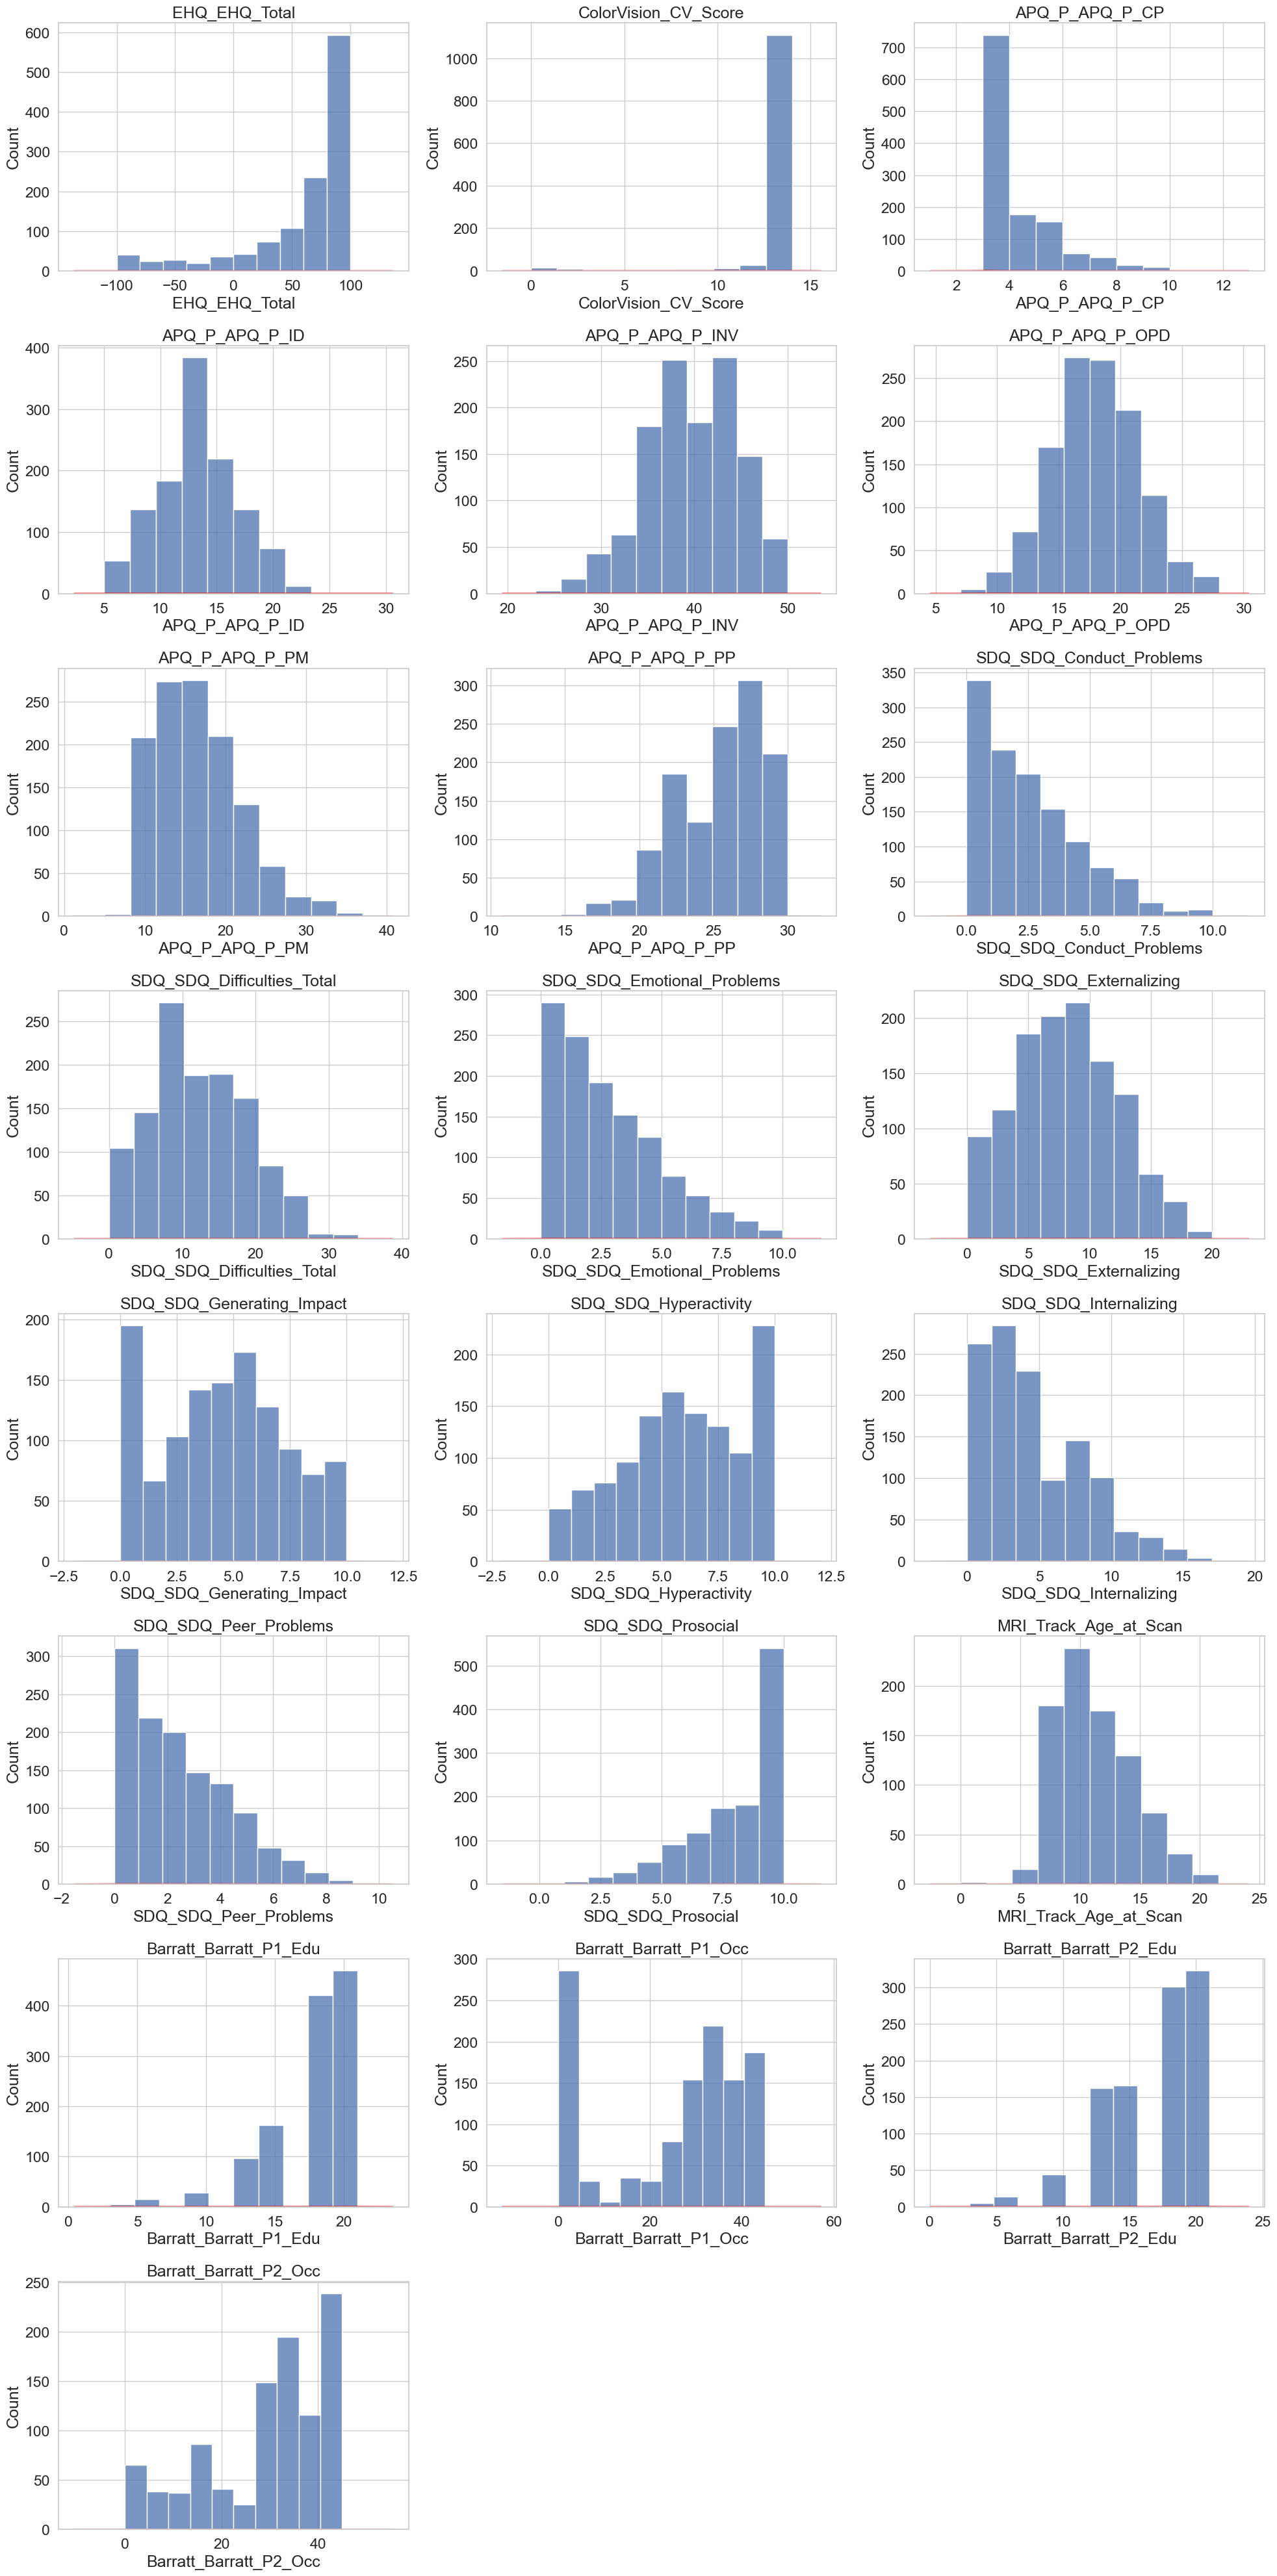

In [25]:
import math

numerical_features = [
    'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan', 'Barratt_Barratt_P1_Edu',
    'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P2_Occ',
]
print(len(numerical_features))

def _plot_numeric_classes(df, col, bins=10, hist=True, kde=True):
    if hist:
        sns.histplot(df[col], bins=bins, kde=False)
    if kde:
        sns.kdeplot(df[col], color="red")

def _distribution_numeric(df, numeric_cols, figsize=(20, 15), bins = 10):
    num_features = len(numeric_cols)

    ncols = 3 
    nrows = math.ceil(num_features / ncols)

    plt.figure(figsize = (figsize[0], nrows * (figsize[1] / 3))) # Adjust figsize based on nrows
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

    for i in range(num_features):
        plt.subplot(nrows, ncols, i + 1)
        _plot_numeric_classes(df, numeric_cols[i], bins = bins)
        plt.title(numeric_cols[i])

    plt.tight_layout() # Adjust layout to prevent titles overlapping
    plt.show()
    
_distribution_numeric(train_combined, numerical_features)

In [26]:
categorical_features = [
    'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
    'MRI_Track_Scan_Location',
]

def _plot_bar_classes(df, cols):
    df[cols].value_counts().plot.bar()

def _distribution_cate(df, cate_cols, row = 1, col = 2, figsize = (20, 5)):
  print('number of category field: ', len(cate_cols))
  plt.figure(figsize = figsize)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)    
  for i in range(1, len(cate_cols)+1, 1):
    try:
      plt.subplot(row, col, i)
      _plot_bar_classes(df, cate_cols[i-1])
      plt.title(cate_cols[i-1])
    except:
      break

# _distribution_cate(train_combined, categorical_features, row = 4, col = 4, figsize = (30, 16))

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ]
)

num_pipeline = Pipeline(
    steps=[
        ('imputer', IterativeImputer(
            estimator=LassoCV(random_state=SEED),
            max_iter=100,
            random_state=SEED,
        )),
        ('scaler', StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ]
)

cleaned_train = preprocessor.fit_transform(train_combined)
# cleaned_test = preprocessor.transform(test_combined)
print("Train shape: ", cleaned_train.shape)
# print("Test shape: ", cleaned_test.shape)

Train shape:  (1213, 50)


In [28]:
from sklearn.model_selection import train_test_split

cleaned_train_df = pd.DataFrame(
    cleaned_train,
    columns=numerical_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)),
    index=train_combined.index
)

# cleaned_train_df_with_labels = pd.merge(cleaned_train_df, train_labels, on='participant_id', how='left').set_index("participant_id")   

In [29]:
# label_columns = ['ADHD_Outcome', 'Sex_F']

# cleaned_train_df_with_labels['stratify_key'] = cleaned_train_df_with_labels[label_columns].astype(str).agg('_'.join, axis=1)

In [30]:
# cleaned_train_df_with_labels.drop(columns=label_columns, inplace=True)

In [31]:
# df_train, df_test = train_test_split(cleaned_train_df_with_labels, test_size=0.2, random_state=SEED, stratify=cleaned_train_df_with_labels[['stratify_key']])

# X_train = df_train.copy()
# y_train = X_train.pop("stratify_key")

# X_test = df_test.copy()
# y_test = X_test.pop("stratify_key")

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [32]:
# X_train

In [33]:
# import numpy as np
# from sklearn.metrics import f1_score

# def weighted_f1(y_true, y_pred):
#     weights = np.where((y_true == 1) & (train_labels['Sex_F'].loc[y_true.index] == 1), 2, 1)
#     return f1_score(y_true, (y_pred > 0.5).astype(int), sample_weight=weights)

PLEASE TRAIN A DEEP NEURAL NETWORK ON THIS DATASET

+ good weight initializations 

 + K-fold cross validation with k = 10, stratified repeated fold with n_repeats = 3  

 + Num epochs = 100 

 + batch size = 64 

 + L2 regularization with l2 lambda = 0.01 

 + dropout rate = 0.3 

 + also add early stopping with patience = 40 


In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam # Using Adam optimizer
import warnings

warnings.filterwarnings("ignore")
SEED = 42
tf.random.set_seed(SEED) 

X = cleaned_train_df.copy()
y = labels.loc[X.index, ['ADHD_Outcome', 'Sex_F']].copy()

stratify_y = labels.loc[X.index, 'ADHD_Outcome'].astype(str) + '_' + labels.loc[X.index, 'Sex_F'].astype(str)

# Convert to numpy arrays for Keras and scikit-learn's split
X_np = X.values
y_np = y.values # Shape (N, 2)
stratify_y_np = stratify_y.values # Shape (N,)

print("Shape of X_np:", X_np.shape)
print("Shape of y_np:", y_np.shape)
print("Shape of stratify_y_np:", stratify_y_np.shape)

Shape of X_np: (1213, 50)
Shape of y_np: (1213, 2)
Shape of stratify_y_np: (1213,)


In [35]:
def calculate_fold_metric(y_true_fold, y_pred_proba_fold, validation_fold_indices, original_train_labels):
    """
    Calculates the average of weighted F1 for ADHD and standard F1 for Sex_F for a fold.

    Args:
        y_true_fold (np.ndarray): True labels for the fold (shape: N_fold, 2) [ADHD_Outcome, Sex_F].
        y_pred_proba_fold (np.ndarray): Predicted probabilities for the fold (shape: N_fold, 2) [ADHD_prob, Sex_prob].
        validation_fold_indices (np.ndarray): Original integer location indices into the full X_np/y_np for this fold.
        original_train_labels (pd.DataFrame): The full original train_labels DataFrame (indexed by participant_id).

    Returns:
        tuple: (average_competition_score, adhd_weighted_f1, sex_f_macro_f1)
    """
    # Convert probabilities to binary predictions using 0.5 threshold
    y_pred_binary_fold = (y_pred_proba_fold > 0.5).astype(int)

    y_true_adhd_fold = y_true_fold[:, 0]
    y_pred_adhd_fold = y_pred_binary_fold[:, 0]
    y_true_sex_fold = y_true_fold[:, 1]
    y_pred_sex_fold = y_pred_binary_fold[:, 1]

    # Get the original participant_ids for the samples in this validation fold
    # Use the indices from the split to lookup in the original X dataframe index
    validation_participant_ids = X.iloc[validation_fold_indices].index
    # Lookup the original Sex_F labels using these participant_ids
    original_sex_f_fold = original_train_labels.loc[validation_participant_ids, 'Sex_F'].values

    # --- Calculate Weighted F1 for ADHD ---
    # Sample weights are 2 if true ADHD is 1 AND original Sex_F is 1 for this sample, else 1
    adhd_sample_weights = np.where((y_true_adhd_fold == 1) & (original_sex_f_fold == 1), 2, 1)

    # Calculate F1 score for ADHD outcome using the sample weights
    # Set zero_division=0 to avoid warnings/errors if no positive predictions/true positives occur in a fold
    adhd_weighted_f1 = f1_score(y_true_adhd_fold, y_pred_adhd_fold, sample_weight=adhd_sample_weights, zero_division=0)

    # --- Calculate Standard F1 for Sex_F ---
    # Calculate Macro F1 for Sex_F (averages F1 for class 0 and class 1)
    sex_f_macro_f1 = f1_score(y_true_sex_fold, y_pred_sex_fold, average='macro', zero_division=0)

    # --- Calculate Competition Average F1 ---
    average_competition_score = (adhd_weighted_f1 + sex_f_macro_f1) / 2

    return average_competition_score, adhd_weighted_f1, sex_f_macro_f1

# --- Define the DNN Model Creation Function ---

def create_dnn_model(input_dim, l2_lambda=0.01, dropout_rate=0.3):
    """
    Creates a Keras Sequential model for multi-output binary classification.
    """
    model = Sequential([
        # Input Layer
        Input(shape=(input_dim,)), # Use Input layer explicitly

        # Hidden Layer 1
        Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),

        # Hidden Layer 2
        Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),

        # Output Layer (2 units for 2 binary outcomes: ADHD, Sex_F)
        Dense(2, activation='sigmoid')
    ])

    # Compile the model
    # Use binary_crossentropy loss as it's two independent binary tasks
    # Keras automatically applies binary_crossentropy to each output and sums the losses
    model.compile(optimizer=Adam(), # Using Adam optimizer
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # We can include accuracy as a basic metric

    return model

In [36]:
# Ensure all necessary libraries are imported
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# Need preprocessor from earlier steps
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")
SEED = 42
tf.random.set_seed(SEED) # Set TF seed for reproducibility
np.random.seed(SEED) # Set numpy seed for other operations

# Assume all previous code cells up to data loading/preprocessing setup are executed,
# and the following variables are available:
# - cleaned_train_df (processed training features, indexed by participant_id)
# - train_labels (original training labels, indexed by participant_id)
# - X_np (numpy array of cleaned_train_df.values)
# - y_np (numpy array of train_labels[['ADHD_Outcome', 'Sex_F']].values)
# - stratify_y_np (numpy array of combined labels for stratification)
# - test_combined (original test data, indexed by participant_id)
# - preprocessor (fitted ColumnTransformer object)
# - create_dnn_model (function to create the model)
# - l2_lambda, dropout_rate, epochs, batch_size, es_patience (hyperparameters)


# --- Define the Competition Metric Function (Corrected) ---
# This version directly uses the Sex_F label from y_true_fold for weighting.
# We'll use this for fold evaluation and adapt it slightly for OOF evaluation.

def calculate_fold_metric_corrected(y_true_fold, y_pred_proba_fold):
    """
    Calculates the average of weighted F1 for ADHD and standard F1 for Sex_F for a fold.
    Assumes y_true_fold has shape (N_fold, 2) with columns [ADHD_Outcome, Sex_F].
    Uses default threshold of 0.5 for binary predictions.
    """
    y_pred_binary_fold = (y_pred_proba_fold > 0.5).astype(int)

    y_true_adhd_fold = y_true_fold[:, 0]
    y_pred_adhd_fold = y_pred_binary_fold[:, 0]
    y_true_sex_fold = y_true_fold[:, 1]
    y_pred_sex_fold = y_pred_binary_fold[:, 1]

    # Sample weights are 2 if true ADHD is 1 AND true Sex_F is 1 for this sample, else 1.
    adhd_sample_weights = np.where((y_true_adhd_fold == 1) & (y_true_sex_fold == 1), 2, 1)

    # Calculate F1 score for ADHD outcome using the sample weights
    adhd_weighted_f1 = f1_score(y_true_adhd_fold, y_pred_adhd_fold, sample_weight=adhd_sample_weights, zero_division=0)

    # Calculate Macro F1 for Sex_F
    sex_f_macro_f1 = f1_score(y_true_sex_fold, y_pred_sex_fold, average='macro', zero_division=0)

    average_competition_score = (adhd_weighted_f1 + sex_f_macro_f1) / 2

    return average_competition_score, adhd_weighted_f1, sex_f_macro_f1

# --- K-fold Cross-Validation Setup ---

n_splits = 10      # Number of folds
n_repeats = 3      # Number of repetitions
epochs = 100       # Max epochs per fold
batch_size = 64    # Batch size
l2_lambda = 0.01   # L2 regularization strength
dropout_rate = 0.3 # Dropout rate
es_patience = 40   # Early stopping patience

# Repeated Stratified K-Fold cross-validator
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)

# Lists to store metrics and OOF predictions
fold_competition_scores = []
fold_adhd_weighted_f1s = []
fold_sex_f_macro_f1s = []
fold_epochs_trained = []

# Lists to collect OOF predictions and corresponding true labels for threshold optimization
oof_preds_list = []
oof_y_true_list = []

# --- Cross-Validation Loop ---

print(f"Starting Repeated Stratified K-Fold Cross-Validation ({n_repeats} repeats of {n_splits} folds)...")
fold_count = 0

for train_index, val_index in rskf.split(X_np, stratify_y_np):
    fold_count += 1
    print(f"\n--- Fold {fold_count}/{n_splits * n_repeats} ---")

    X_train_fold, X_val_fold = X_np[train_index], X_np[val_index]
    y_train_fold, y_val_fold = y_np[train_index], y_np[val_index] # y_np shape (N, 2)

    model = create_dnn_model(input_dim=X_train_fold.shape[1], l2_lambda=l2_lambda, dropout_rate=dropout_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True)

    print(f"Training model for Fold {fold_count}...")
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping],
                        verbose=0) # Set verbose=1 to see training progress per epoch

    epochs_ran = len(history.history['loss'])
    print(f"Finished training for Fold {fold_count}. Epochs trained: {epochs_ran}")
    fold_epochs_trained.append(epochs_ran)

    # --- Evaluate on the Validation Fold using the Competition Metric (Default Threshold 0.5) ---
    print("Evaluating on validation fold (using default 0.5 threshold)...")
    val_preds_proba = model.predict(X_val_fold)

    # Calculate the custom competition metric with default 0.5 threshold
    fold_comp_score, fold_adhd_w_f1, fold_sex_f_f1 = calculate_fold_metric_corrected(
        y_val_fold,
        val_preds_proba
    )

    print(f"Fold {fold_count} Metrics (Default 0.5 Threshold):")
    print(f"  Weighted ADHD F1: {fold_adhd_w_f1:.4f}")
    print(f"  Sex_F Macro F1:   {fold_sex_f_f1:.4f}")
    print(f"  Competition Avg F1: {fold_comp_score:.4f}")

    # Store fold metrics
    fold_competition_scores.append(fold_comp_score)
    fold_adhd_weighted_f1s.append(fold_adhd_w_f1)
    fold_sex_f_macro_f1s.append(fold_sex_f_f1)

    # --- Collect OOF Predictions and True Labels ---
    oof_preds_list.append(val_preds_proba)
    oof_y_true_list.append(y_val_fold)


print("\n--- Cross-Validation Complete ---")

# --- Aggregate OOF Predictions and True Labels ---
# Concatenate predictions and true labels from all validation folds
all_oof_preds = np.concatenate(oof_preds_list, axis=0)
all_oof_y_true = np.concatenate(oof_y_true_list, axis=0)

print(f"\nAggregated OOF predictions shape: {all_oof_preds.shape}")
print(f"Aggregated OOF true labels shape: {all_oof_y_true.shape}")


# --- Summarize CV Results (using default 0.5 threshold) ---

avg_comp_score_default_thresh = np.mean(fold_competition_scores)
std_comp_score_default_thresh = np.std(fold_competition_scores)
avg_adhd_w_f1_default_thresh = np.mean(fold_adhd_weighted_f1s)
std_adhd_w_f1_default_thresh = np.std(fold_adhd_weighted_f1s)
avg_sex_f_f1_default_thresh = np.mean(fold_sex_f_macro_f1s)
std_sex_f_f1_default_thresh = np.std(fold_sex_f_macro_f1s)
avg_epochs = np.mean(fold_epochs_trained)

print("\n--- Cross-Validation Results Summary (Default 0.5 Threshold) ---")
print(f"Total Folds Run: {fold_count}")
print(f"Average Epochs Trained per Fold: {avg_epochs:.1f}")
print("\nAverage Metrics Across All Folds:")
print(f"  Weighted ADHD F1: {avg_adhd_w_f1_default_thresh:.4f} +/- {std_adhd_w_f1_default_thresh:.4f}")
print(f"  Sex_F Macro F1:   {avg_sex_f_f1_default_thresh:.4f} +/- {std_sex_f_f1_default_thresh:.4f}")
print(f"  Competition Avg F1: {avg_comp_score_default_thresh:.4f} +/- {std_comp_score_default_thresh:.4f}")


# --- Threshold Optimization on OOF Predictions ---

print("\n--- Starting Threshold Optimization on OOF Data ---")

# Define the metric function for OOF data using specific thresholds
def calculate_oof_metric_with_thresholds(y_true_oof, y_pred_proba_oof, adhd_threshold, sex_f_threshold):
    """
    Calculates the competition metric on OOF data using specific thresholds.
    """
    y_pred_binary_oof = np.zeros_like(y_pred_proba_oof, dtype=int)
    # Apply the specified thresholds for binarization
    y_pred_binary_oof[:, 0] = (y_pred_proba_oof[:, 0] > adhd_threshold).astype(int)
    y_pred_binary_oof[:, 1] = (y_pred_proba_oof[:, 1] > sex_f_threshold).astype(int)

    y_true_adhd = y_true_oof[:, 0]
    y_pred_adhd = y_pred_binary_oof[:, 0]
    y_true_sex = y_true_oof[:, 1]
    y_pred_sex = y_pred_binary_oof[:, 1]

    # Weighted F1 for ADHD (uses true Sex_F for weight)
    adhd_sample_weights = np.where((y_true_adhd == 1) & (y_true_sex == 1), 2, 1)
    adhd_weighted_f1 = f1_score(y_true_adhd, y_pred_adhd, sample_weight=adhd_sample_weights, zero_division=0)

    # Macro F1 for Sex_F
    sex_f_macro_f1 = f1_score(y_true_sex, y_pred_sex, average='macro', zero_division=0)

    return (adhd_weighted_f1 + sex_f_macro_f1) / 2

# Grid search for the best thresholds
# Search range: 0.1 to 0.9 with a step of 0.01
threshold_range = np.arange(0.1, 0.91, 0.01)

best_oof_score = -1
best_adhd_thresh = 0.5 # Start with default
best_sex_f_thresh = 0.5 # Start with default

print(f"Searching thresholds from {threshold_range[0]:.2f} to {threshold_range[-1]:.2f} with step {threshold_range[1]-threshold_range[0]:.2f}...")
# This nested loop can be slow, consider a coarser range or smarter search for production
for adhd_thresh in threshold_range:
    for sex_f_thresh in threshold_range:
        score = calculate_oof_metric_with_thresholds(all_oof_y_true, all_oof_preds, adhd_thresh, sex_f_thresh)

        if score > best_oof_score:
            best_oof_score = score
            best_adhd_thresh = adhd_thresh
            best_sex_f_thresh = sex_f_thresh

print("\n--- Threshold Optimization Complete ---")
print(f"Best OOF Competition Score: {best_oof_score:.4f}")
print(f"Optimal ADHD Threshold: {best_adhd_thresh:.4f}")
print(f"Optimal Sex_F Threshold: {best_sex_f_thresh:.4f}")
print(f"Improvement over Default 0.5 Threshold: {best_oof_score - avg_comp_score_default_thresh:.4f}")


# --- Load and Preprocess Test Data ---
# (This block is repeated from the previous response to ensure it's here)
print("\n--- Loading and Preprocessing Test Data ---")

# test_q and test_c should be loaded, test_combined created and indexed as before
# test_q = pd.read_excel("data/TEST/TEST_QUANTITATIVE_METADATA.xlsx") # Assumed loaded
# test_c = pd.read_excel("data/TEST/TEST_CATEGORICAL_METADATA.xlsx") # Assumed loaded
# test_combined = pd.merge(test_q, test_c, on='participant_id', how='left').set_index("participant_id") # Assumed created

# Apply the preprocessor (FIT ON TRAIN, TRANSFORM ON TEST)
cleaned_test = preprocessor.transform(test_combined)

# Convert processed test data back to DataFrame (optional but good for clarity)
# Get column names from the preprocessor after it was fitted on train data
num_cols_out = [col for col in numerical_features]
cat_transformer = preprocessor.named_transformers_['cat']
cat_cols_out = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
all_cols_out = list(num_cols_out) + list(cat_cols_out)

cleaned_test_df = pd.DataFrame(
    cleaned_test,
    columns=all_cols_out,
    index=test_combined.index
)

X_test_np = cleaned_test_df.values

print("Shape of preprocessed test data (cleaned_test_df):", cleaned_test_df.shape)
print("Shape of test data numpy array (X_test_np):", X_test_np.shape)


# --- Train Final Model on Entire Training Data ---

print("\n--- Training Final Model on Entire Training Data ---")

final_model = create_dnn_model(input_dim=X_np.shape[1], l2_lambda=l2_lambda, dropout_rate=dropout_rate)

final_epochs = max(1, int(np.ceil(avg_epochs))) # Use average epochs from CV

print(f"Training final model for {final_epochs} epochs on the entire training dataset ({X_np.shape[0]} samples)...")

final_model.fit(X_np, y_np,
                epochs=final_epochs,
                batch_size=batch_size,
                verbose=1)

print("Finished training final model.")


# --- Make Predictions on Test Data ---

print("\n--- Making Predictions on Test Data ---")

# Predict probabilities on the preprocessed test data
test_predictions_proba = final_model.predict(X_test_np)

print("Shape of test predictions (probabilities):", test_predictions_proba.shape)


# --- Create Submission File (using probabilities) ---

print("\n--- Creating Submission File ---")

# Get the participant_ids from the original test data.
test_participant_ids = test_combined.index

# Create the submission DataFrame
# The submission format requires probabilities ("real value"), NOT binary predictions
submission_df = pd.DataFrame({
    'participant_id': test_participant_ids,
    'ADHD_Outcome': test_predictions_proba[:, 0], # ADHD probabilities
    'Sex_F': test_predictions_proba[:, 1]        # Sex_F probabilities
})

# Ensure the columns are in the exact order required
submission_df = submission_df[['participant_id', 'ADHD_Outcome', 'Sex_F']]

# Print the head of the submission DataFrame
print("\nSubmission file head:")
print(submission_df.head())

# Save the submission DataFrame to a CSV file
submission_filename = "submission.csv"
# Use index=False and default comma separator
submission_df.to_csv(submission_filename, index=False)

print(f"\nSubmission file successfully created and saved as '{submission_filename}'")

# Note: The optimal thresholds found are for evaluating performance internally.
# The submission file itself contains the raw probabilities.

Starting Repeated Stratified K-Fold Cross-Validation (3 repeats of 10 folds)...

--- Fold 1/30 ---
Training model for Fold 1...
Finished training for Fold 1. Epochs trained: 87
Evaluating on validation fold (using default 0.5 threshold)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 1 Metrics (Default 0.5 Threshold):
  Weighted ADHD F1: 0.8621
  Sex_F Macro F1:   0.4953
  Competition Avg F1: 0.6787

--- Fold 2/30 ---
Training model for Fold 2...
Finished training for Fold 2. Epochs trained: 78
Evaluating on validation fold (using default 0.5 threshold)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 2 Metrics (Default 0.5 Threshold):
  Weighted ADHD F1: 0.9083
  Sex_F Macro F1:   0.5956
  Competition Avg F1: 0.7520

--- Fold 3/30 ---
Training model for Fold 3...
Finished training for Fold 3. Epochs trained: 76
Evaluating on validation fold (using default 0.5 threshold)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 3 Metrics (Default 0.5 Threshold):
  Weighted ADHD F1: 0.8634
  Sex_F Macro

In [37]:
# --- Load and Preprocess Test Data ---
# (This block is repeated for completeness, assume it's run)
print("\n--- Loading and Preprocessing Test Data ---")
# test_q and test_c loaded, test_combined created and indexed as before
# preprocessor is already fitted on training data
cleaned_test = preprocessor.transform(test_combined)
# Convert processed test data back to DataFrame and then numpy
num_cols_out = [col for col in numerical_features]
cat_transformer = preprocessor.named_transformers_['cat']
cat_cols_out = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
all_cols_out = list(num_cols_out) + list(cat_cols_out)
cleaned_test_df = pd.DataFrame(cleaned_test, columns=all_cols_out, index=test_combined.index)
X_test_np = cleaned_test_df.values
print("Shape of preprocessed test data (X_test_np):", X_test_np.shape)


# --- Train Final Model on Entire Training Data ---
# (This block is repeated for completeness, assume it's run)
print("\n--- Training Final Model on Entire Training Data ---")
final_model = create_dnn_model(input_dim=X_np.shape[1], l2_lambda=l2_lambda, dropout_rate=dropout_rate)
final_epochs = max(1, int(np.ceil(avg_epochs)))
print(f"Training final model for {final_epochs} epochs...")
final_model.fit(X_np, y_np, epochs=final_epochs, batch_size=batch_size, verbose=1)
print("Finished training final model.")


# --- Make Predictions on Test Data (Probabilities) ---
# (This block is repeated for completeness, assume it's run)
print("\n--- Making Predictions on Test Data (Probabilities) ---")
test_predictions_proba = final_model.predict(X_test_np)
print("Shape of test predictions (probabilities):", test_predictions_proba.shape)


# --- Create Submission File (using Optimal Thresholds for Binary Output) ---

print("\n--- Creating Submission File (using optimal thresholds for binary output) ---")

# Get the participant_ids from the original test data.
test_participant_ids = test_combined.index

# Apply the optimal thresholds found during OOF optimization to convert probabilities to binary (0 or 1)
# best_adhd_thresh and best_sex_f_thresh should be available from the threshold optimization code block
test_predictions_binary = np.zeros_like(test_predictions_proba, dtype=int)
# Binarize ADHD predictions using the optimal ADHD threshold
test_predictions_binary[:, 0] = (test_predictions_proba[:, 0] > best_adhd_thresh).astype(int)
# Binarize Sex_F predictions using the optimal Sex_F threshold
test_predictions_binary[:, 1] = (test_predictions_proba[:, 1] > best_sex_f_thresh).astype(int)

# Create the submission DataFrame using the **binary** predictions
submission_df = pd.DataFrame({
    'participant_id': test_participant_ids,
    'ADHD_Outcome': test_predictions_binary[:, 0], # Use binary ADHD predictions (0 or 1)
    'Sex_F': test_predictions_binary[:, 1]        # Use binary Sex_F predictions (0 or 1)
})

# Ensure the columns are in the exact order required
submission_df = submission_df[['participant_id', 'ADHD_Outcome', 'Sex_F']]

# Print the head of the submission DataFrame
print("\nSubmission file head (binary predictions):")
print(submission_df.head())

# Save the submission DataFrame to a CSV file
# Using a different filename like 'submission_binary.csv' is good practice
submission_filename = "submission_binary.csv"
# Use index=False and default comma separator
submission_df.to_csv(submission_filename, index=False)

print(f"\nBinary submission file successfully created and saved as '{submission_filename}'")

# Note: This submission file contains 0s and 1s based on your optimal thresholds.
# Some competitions require probabilities even if the metric is F1; always double-check
# the specific submission requirements for the competition platform. Based on your
# request and example, we generated the binary output.


--- Loading and Preprocessing Test Data ---
Shape of preprocessed test data (X_test_np): (304, 50)

--- Training Final Model on Entire Training Data ---
Training final model for 86 epochs...
Epoch 1/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6239 - loss: 2.2144   
Epoch 2/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 1.8248 
Epoch 3/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8495 - loss: 1.5504 
Epoch 4/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8449 - loss: 1.3268 
Epoch 5/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8439 - loss: 1.1527 
Epoch 6/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8306 - loss: 1.0213 
Epoch 7/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8188 - loss: 0.9185 
Epoch 8/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8164 - loss: 0.8393 
Epoch 9/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8323 - loss: 0.7698 
Epoch 10/86
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s